In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import shap
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set style for high-quality plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12

print("XGBoost Regression Model Training")
print("="*50)


XGBoost Regression Model Training


In [15]:
# Load the preprocessed data
print("Loading preprocessed data...")

X_train = pd.read_parquet('X_train.parquet')
X_test = pd.read_parquet('X_test.parquet')
y_train = pd.read_parquet('y_train.parquet')['ap_hi']
y_test = pd.read_parquet('y_test.parquet')['ap_hi']

# Load feature information
with open('feature_info.pkl', 'rb') as f:
    feature_info = pickle.load(f)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Target variable: {feature_info['target_variable']}")
print(f"Total features: {feature_info['total_features']}")

# Display basic statistics
print(f"\nTarget statistics:")
print(f"Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")


Loading preprocessed data...
Training set: (61799, 24)
Test set: (6867, 24)
Target variable: ap_hi
Total features: 24

Target statistics:
Train - Mean: 126.67, Std: 16.66
Test  - Mean: 126.70, Std: 16.84


In [16]:
# STEP 1: Hyperparameter Tuning
print("\nSTEP 1: Hyperparameter Tuning")
print("="*50)

# Define parameter grid for RandomizedSearchCV (more efficient than GridSearch)
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1, 1.5, 2.0, 2.5],
    'min_child_weight': [1, 3, 5]
}

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Perform randomized search
print("Performing hyperparameter tuning...")
print("This may take several minutes...")

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter combinations to try
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the random search
random_search.fit(X_train, y_train)

# Get best parameters
best_params = random_search.best_params_
print(f"\nBest parameters found:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"Best CV score (negative MSE): {random_search.best_score_:.4f}")
print(f"Best CV RMSE: {np.sqrt(-random_search.best_score_):.4f}")



STEP 1: Hyperparameter Tuning
Performing hyperparameter tuning...
This may take several minutes...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found:
  subsample: 0.9
  reg_lambda: 2.5
  reg_alpha: 1.0
  n_estimators: 300
  min_child_weight: 1
  max_depth: 3
  learning_rate: 0.05
  colsample_bytree: 1.0
Best CV score (negative MSE): -115.6216
Best CV RMSE: 10.7527


In [17]:
# STEP 2: Train model with best parameters on full dataset
print("\nSTEP 2: Training Final Model")
print("="*50)

# Combine train and test sets for final training
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

print(f"Full dataset size: {X_full.shape[0]} samples")

# Create final model with best parameters
final_model = xgb.XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Train on full dataset
print("Training final model on full dataset...")
final_model.fit(X_full, y_full)

# Also keep a model trained only on training set for comparison
train_model = xgb.XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
train_model.fit(X_train, y_train)

print("Model training complete!")



STEP 2: Training Final Model
Full dataset size: 68666 samples
Training final model on full dataset...
Model training complete!


In [18]:
# STEP 3: Generate predictions and calculate metrics
print("\nSTEP 3: Model Evaluation and Metrics")
print("="*50)

# Predictions from train-only model
y_train_pred = train_model.predict(X_train)
y_test_pred = train_model.predict(X_test)

# Predictions from full-data model
y_full_pred = final_model.predict(X_full)

# Calculate metrics function
def calculate_metrics(y_true, y_pred, set_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Standard error (standard deviation of residuals)
    residuals = y_true - y_pred
    std_error = np.std(residuals)

    return {
        'Dataset': set_name,
        'Mean_Absolute_Error': mae,
        'Standard_Error': std_error,
        'RMSE': rmse,
        'R2_Score': r2,
        'MSE': mse
    }

# Calculate metrics for all sets
metrics_list = []
metrics_list.append(calculate_metrics(y_train, y_train_pred, 'Train'))
metrics_list.append(calculate_metrics(y_test, y_test_pred, 'Test'))
metrics_list.append(calculate_metrics(y_full, y_full_pred, 'Full_Dataset'))

# Create metrics dataframe
metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.round(4)

print("Model Performance Metrics:")
print("="*60)
print(metrics_df.to_string(index=False))

# Save metrics
metrics_df.to_csv('model_metrics.csv', index=False)
print("\n✓ Metrics saved to model_metrics.csv")



STEP 3: Model Evaluation and Metrics
Model Performance Metrics:
     Dataset  Mean_Absolute_Error  Standard_Error    RMSE  R2_Score      MSE
       Train               7.2807         10.6337 10.6337    0.5927 113.0746
        Test               7.3892         10.7963 10.7964    0.5891 116.5628
Full_Dataset               7.2878         10.6483 10.6483    0.5925 113.3853

✓ Metrics saved to model_metrics.csv



STEP 4: Visualization - True vs Predicted


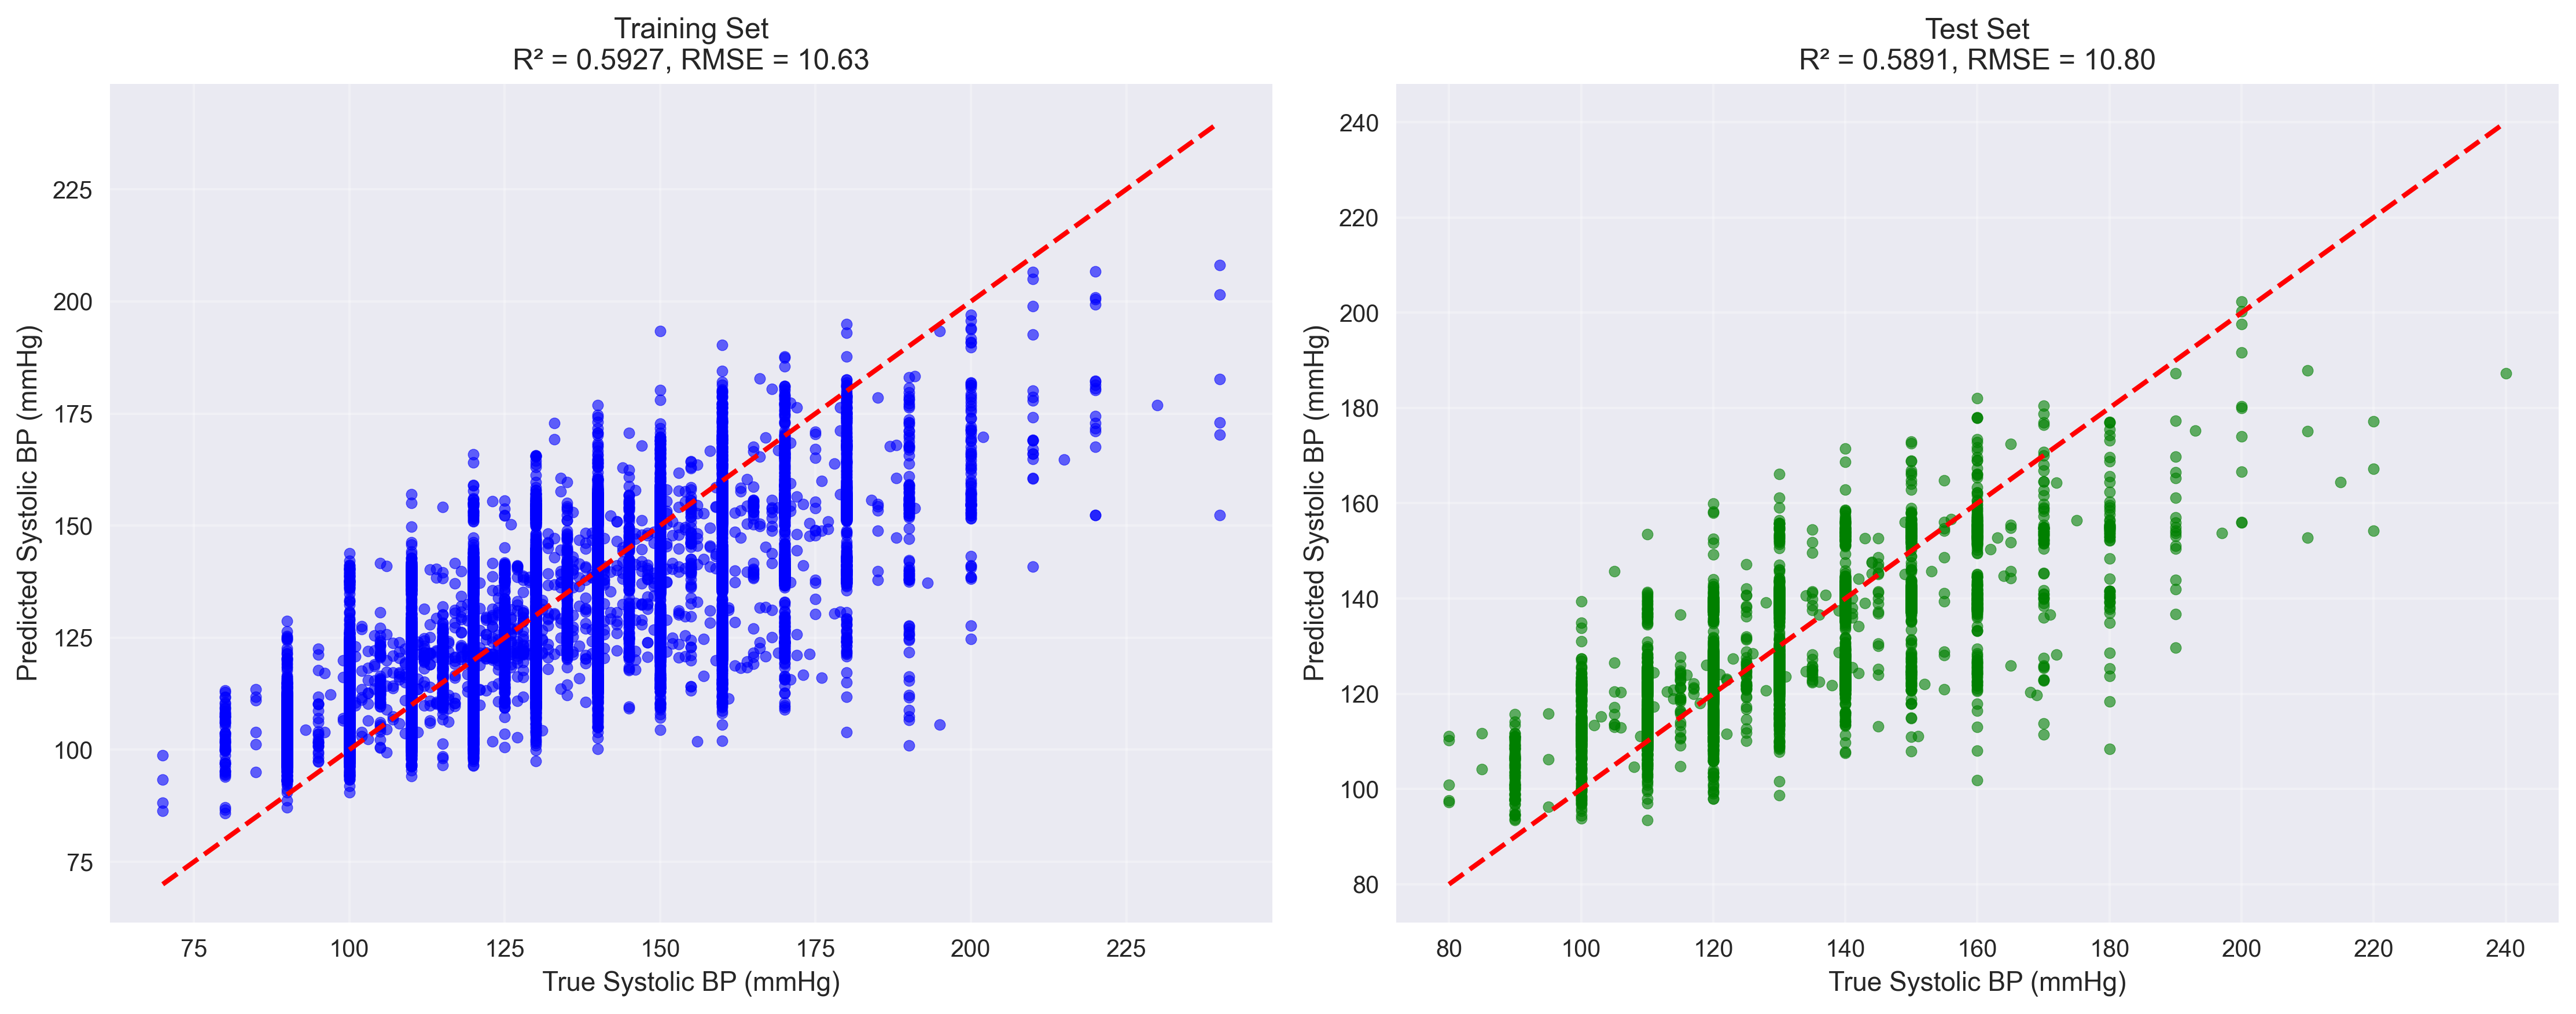

✓ True vs Predicted plots saved as vector (SVG) and PNG


In [19]:
# STEP 4: Plot True vs Predicted values
print("\nSTEP 4: Visualization - True vs Predicted")
print("="*50)

# Create subplots for train and test predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Train set plot
axes[0].scatter(y_train, y_train_pred, alpha=0.6, color='blue', s=20)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('True Systolic BP (mmHg)')
axes[0].set_ylabel('Predicted Systolic BP (mmHg)')
axes[0].set_title(f'Training Set\nR² = {metrics_df.loc[0, "R2_Score"]:.4f}, RMSE = {metrics_df.loc[0, "RMSE"]:.2f}')
axes[0].grid(True, alpha=0.3)

# Test set plot
axes[1].scatter(y_test, y_test_pred, alpha=0.6, color='green', s=20)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('True Systolic BP (mmHg)')
axes[1].set_ylabel('Predicted Systolic BP (mmHg)')
axes[1].set_title(f'Test Set\nR² = {metrics_df.loc[1, "R2_Score"]:.4f}, RMSE = {metrics_df.loc[1, "RMSE"]:.2f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('true_vs_predicted.svg', format='svg', dpi=300, bbox_inches='tight')
plt.savefig('true_vs_predicted.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ True vs Predicted plots saved as vector (SVG) and PNG")


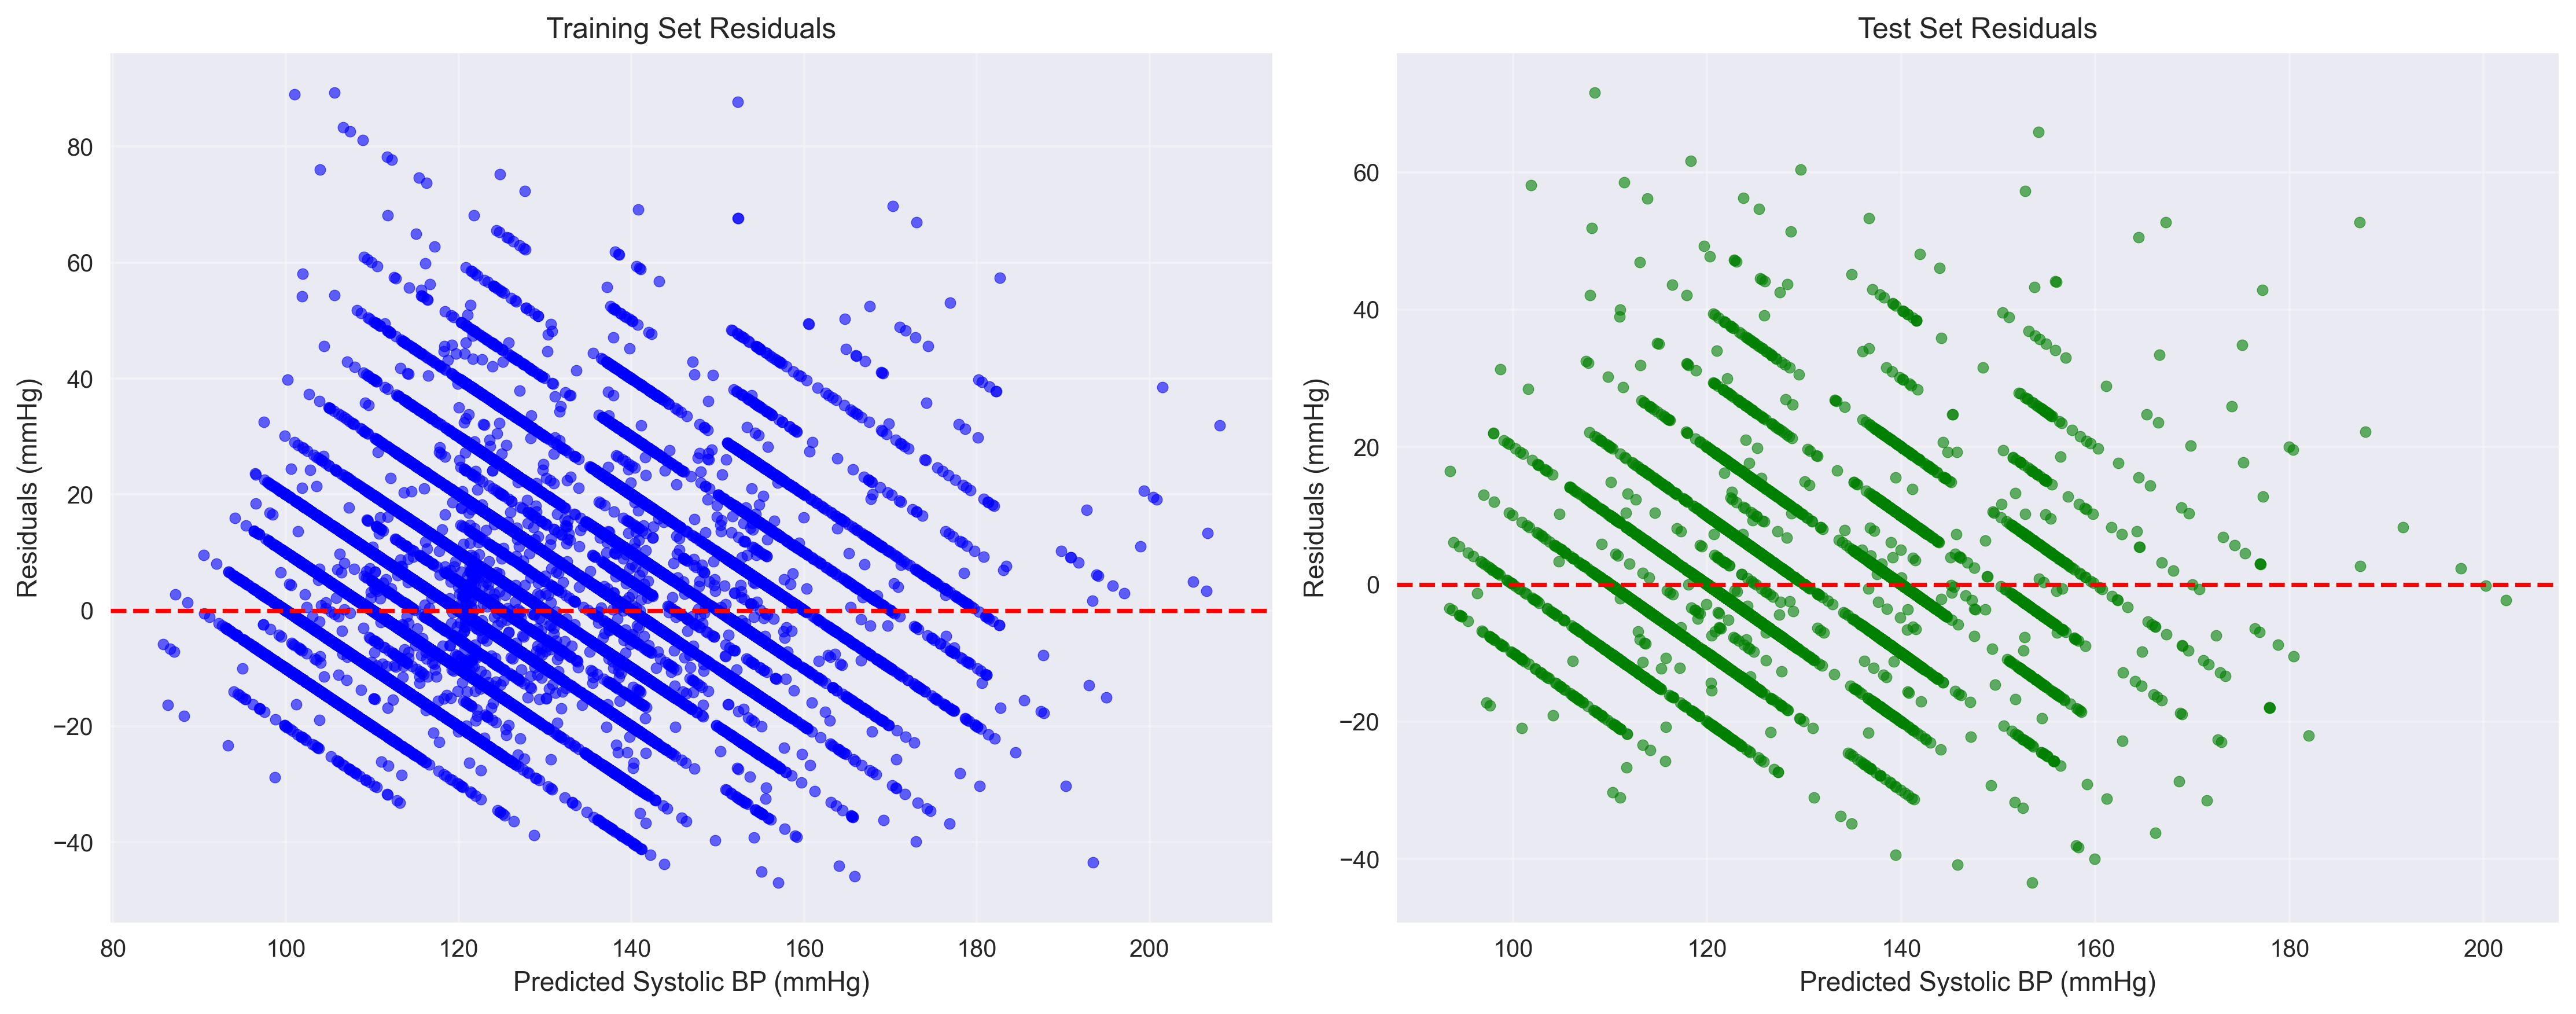

✓ Residual plots saved as vector (SVG) and PNG


In [20]:
# Additional residual plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Residual plot for train
train_residuals = y_train - y_train_pred
axes[0].scatter(y_train_pred, train_residuals, alpha=0.6, color='blue', s=20)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Systolic BP (mmHg)')
axes[0].set_ylabel('Residuals (mmHg)')
axes[0].set_title('Training Set Residuals')
axes[0].grid(True, alpha=0.3)

# Residual plot for test
test_residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, test_residuals, alpha=0.6, color='green', s=20)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Systolic BP (mmHg)')
axes[1].set_ylabel('Residuals (mmHg)')
axes[1].set_title('Test Set Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residual_plots.svg', format='svg', dpi=300, bbox_inches='tight')
plt.savefig('residual_plots.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Residual plots saved as vector (SVG) and PNG")


In [21]:
# STEP 5: SHAP Analysis with actual feature names
print("\nSTEP 5: SHAP Analysis and Feature Importance")
print("="*50)

# Create feature names mapping
def create_feature_names():
    """Create meaningful feature names from the preprocessing info"""
    feature_names = []

    # Add numerical features
    numerical_features = feature_info['numerical_features']
    for feat in numerical_features:
        if feat in ['age', 'height', 'weight', 'ap_lo']:
            feature_names.append(feat)
        elif 'age_years' in feat:
            feature_names.append('Age (years)')
        elif 'bmi' in feat:
            feature_names.append('BMI')
        elif 'interaction' in feat:
            feature_names.append(feat.replace('_', ' ').title())
        else:
            feature_names.append(feat.replace('_', ' ').title())

    # Add categorical features (cholesterol, glucose)
    cat_features = ['cholesterol', 'gluc']
    for cat in cat_features:
        if cat == 'cholesterol':
            feature_names.extend(['Cholesterol_High', 'Cholesterol_Very_High'])
        elif cat == 'gluc':
            feature_names.extend(['Glucose_High', 'Glucose_Very_High'])

    # Add binary features
    binary_features = ['gender', 'smoke', 'alco', 'active']
    binary_names = ['Gender_Male', 'Smoking', 'Alcohol', 'Physical_Activity']
    feature_names.extend(binary_names)

    return feature_names

# Get feature names
try:
    if len(feature_info['feature_names']) == X_train.shape[1]:
        feature_names = feature_info['feature_names']
    else:
        feature_names = create_feature_names()
except:
    feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]

# Ensure we have the right number of feature names
if len(feature_names) != X_train.shape[1]:
    feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]

print(f"Using {len(feature_names)} feature names for SHAP analysis")

# Initialize SHAP explainer
print("Initializing SHAP explainer...")
explainer = shap.Explainer(train_model)

# Calculate SHAP values (use a sample for speed)
sample_size = min(1000, len(X_test))
X_sample = X_test.iloc[:sample_size]
print(f"Calculating SHAP values for {sample_size} samples...")

shap_values = explainer(X_sample)



STEP 5: SHAP Analysis and Feature Importance
Using 24 feature names for SHAP analysis
Initializing SHAP explainer...
Calculating SHAP values for 1000 samples...


Creating SHAP summary plot...


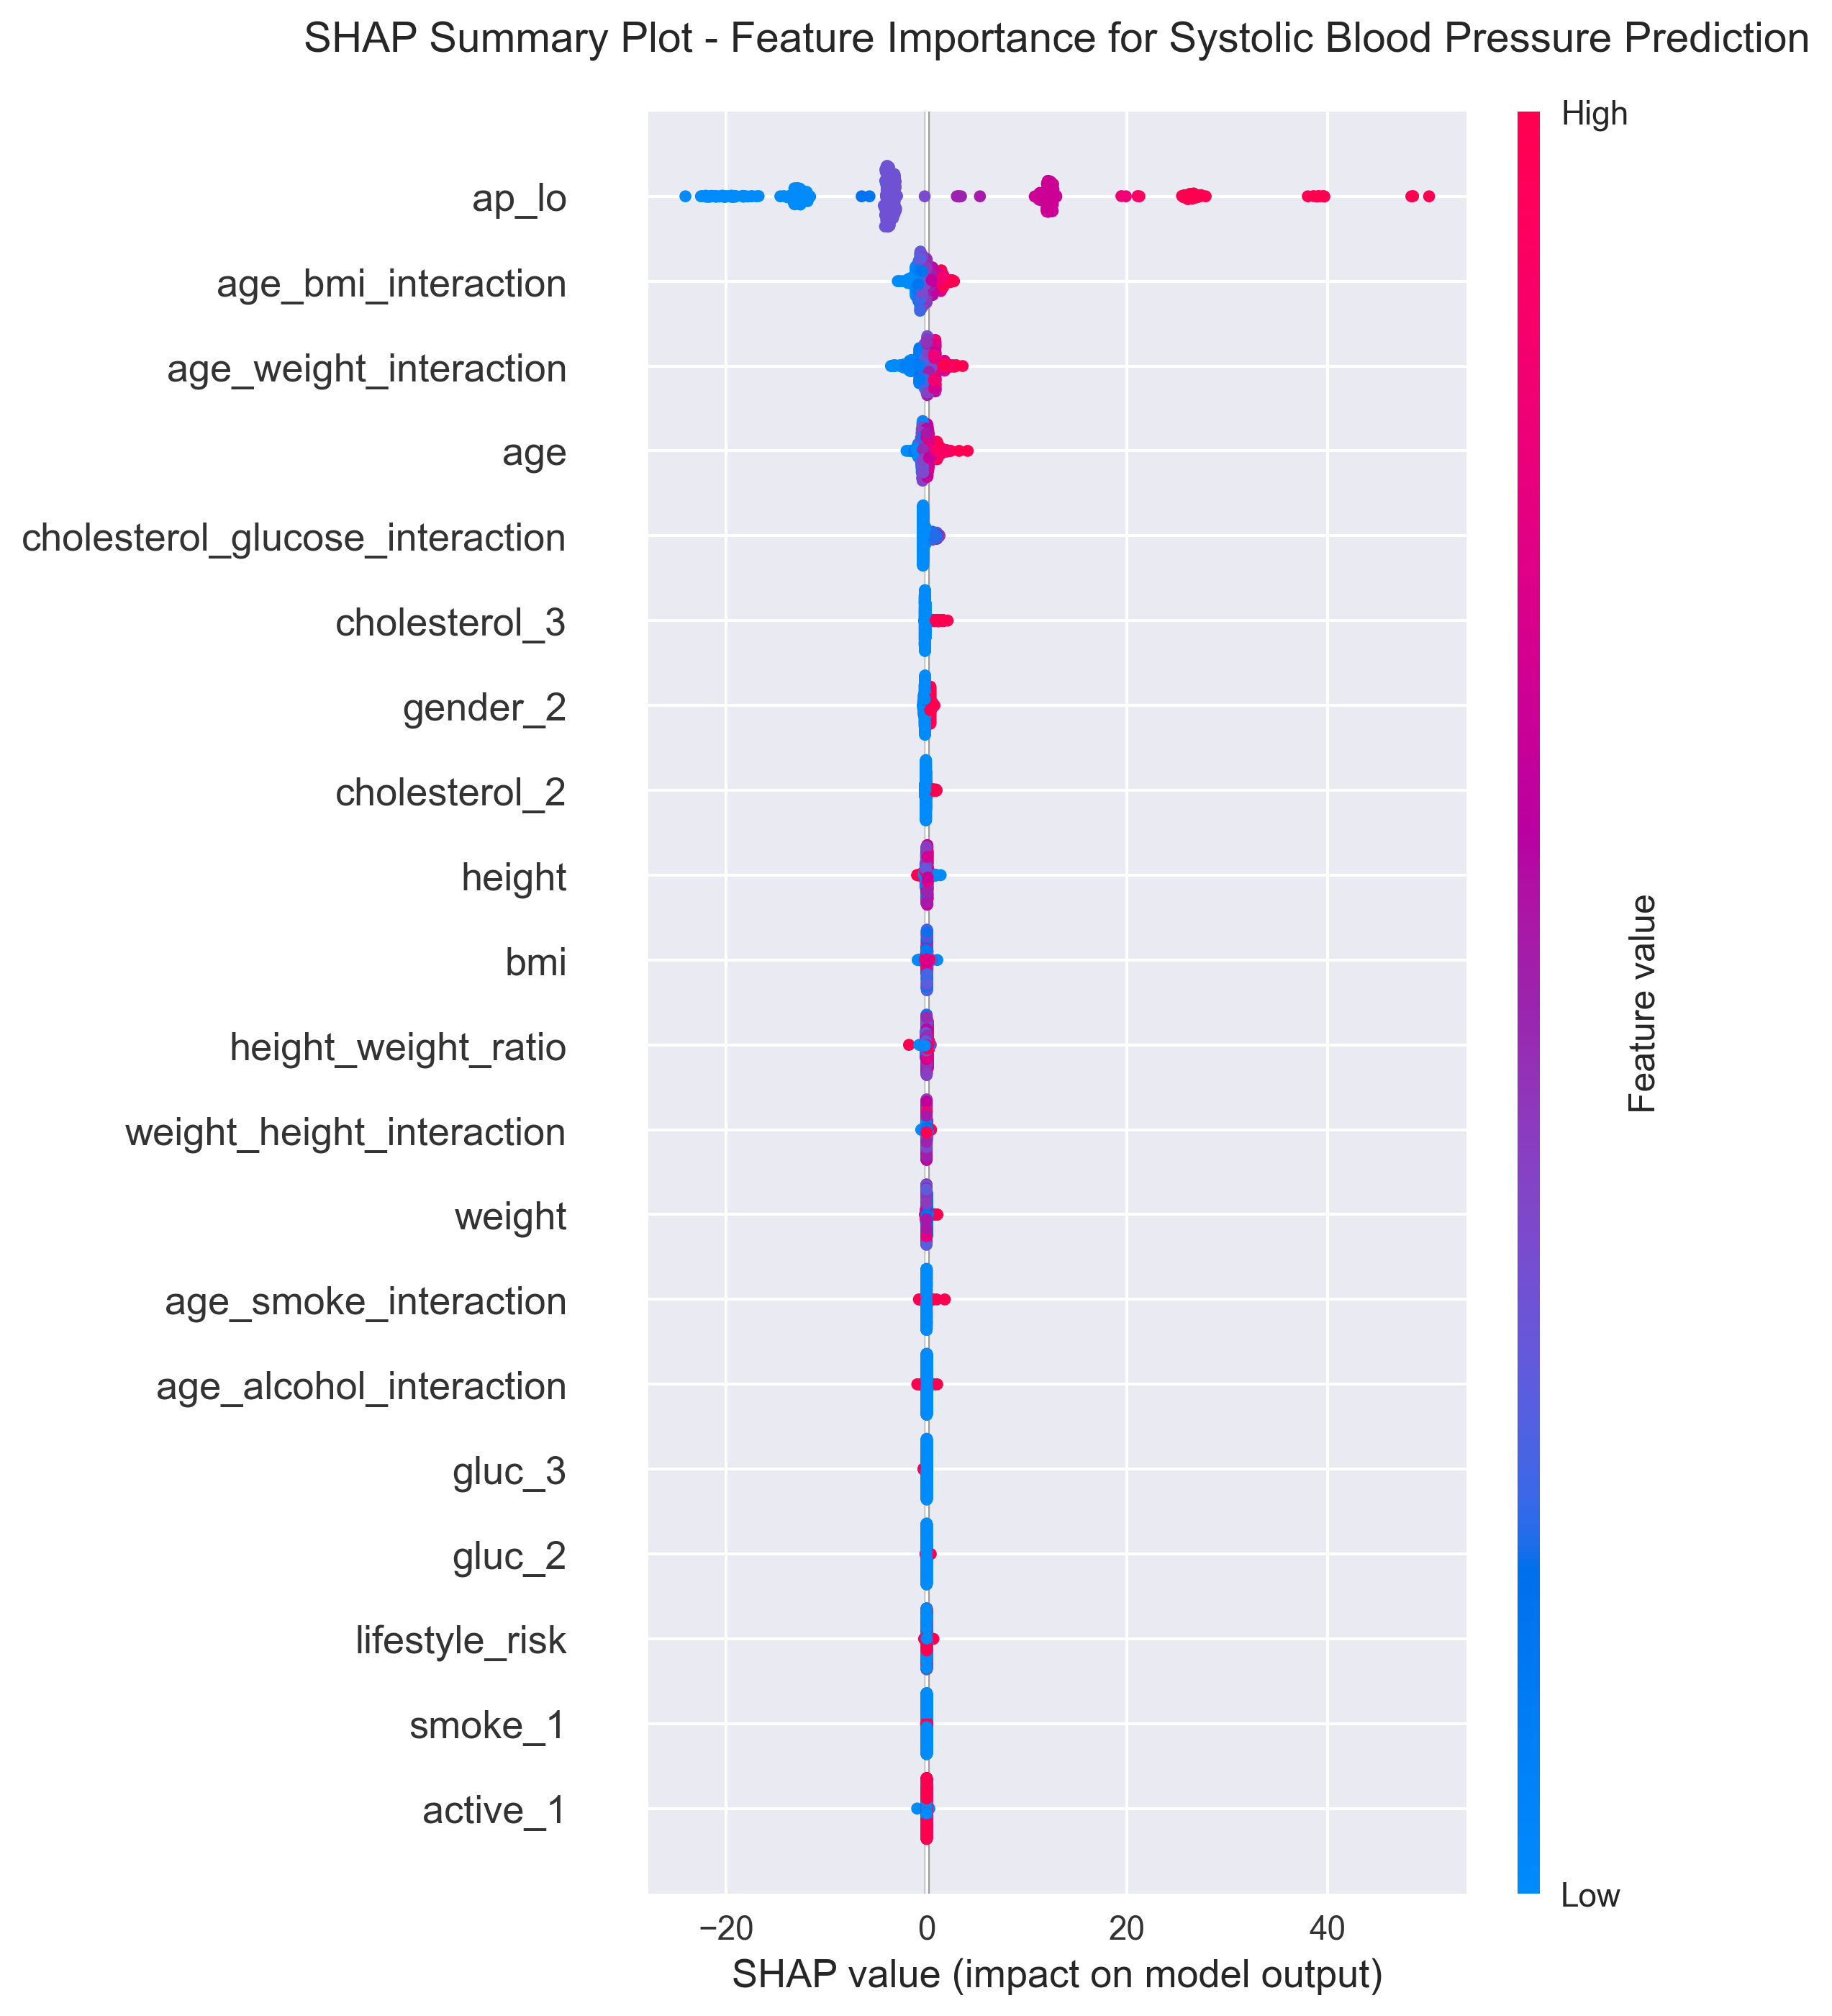

✓ SHAP summary plot saved as vector (SVG) and PNG


In [22]:
# SHAP Summary Plot
print("Creating SHAP summary plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
plt.title('SHAP Summary Plot - Feature Importance for Systolic Blood Pressure Prediction', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('shap_summary_plot.svg', format='svg', dpi=300, bbox_inches='tight')
plt.savefig('shap_summary_plot.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP summary plot saved as vector (SVG) and PNG")


Creating SHAP dependency plots...


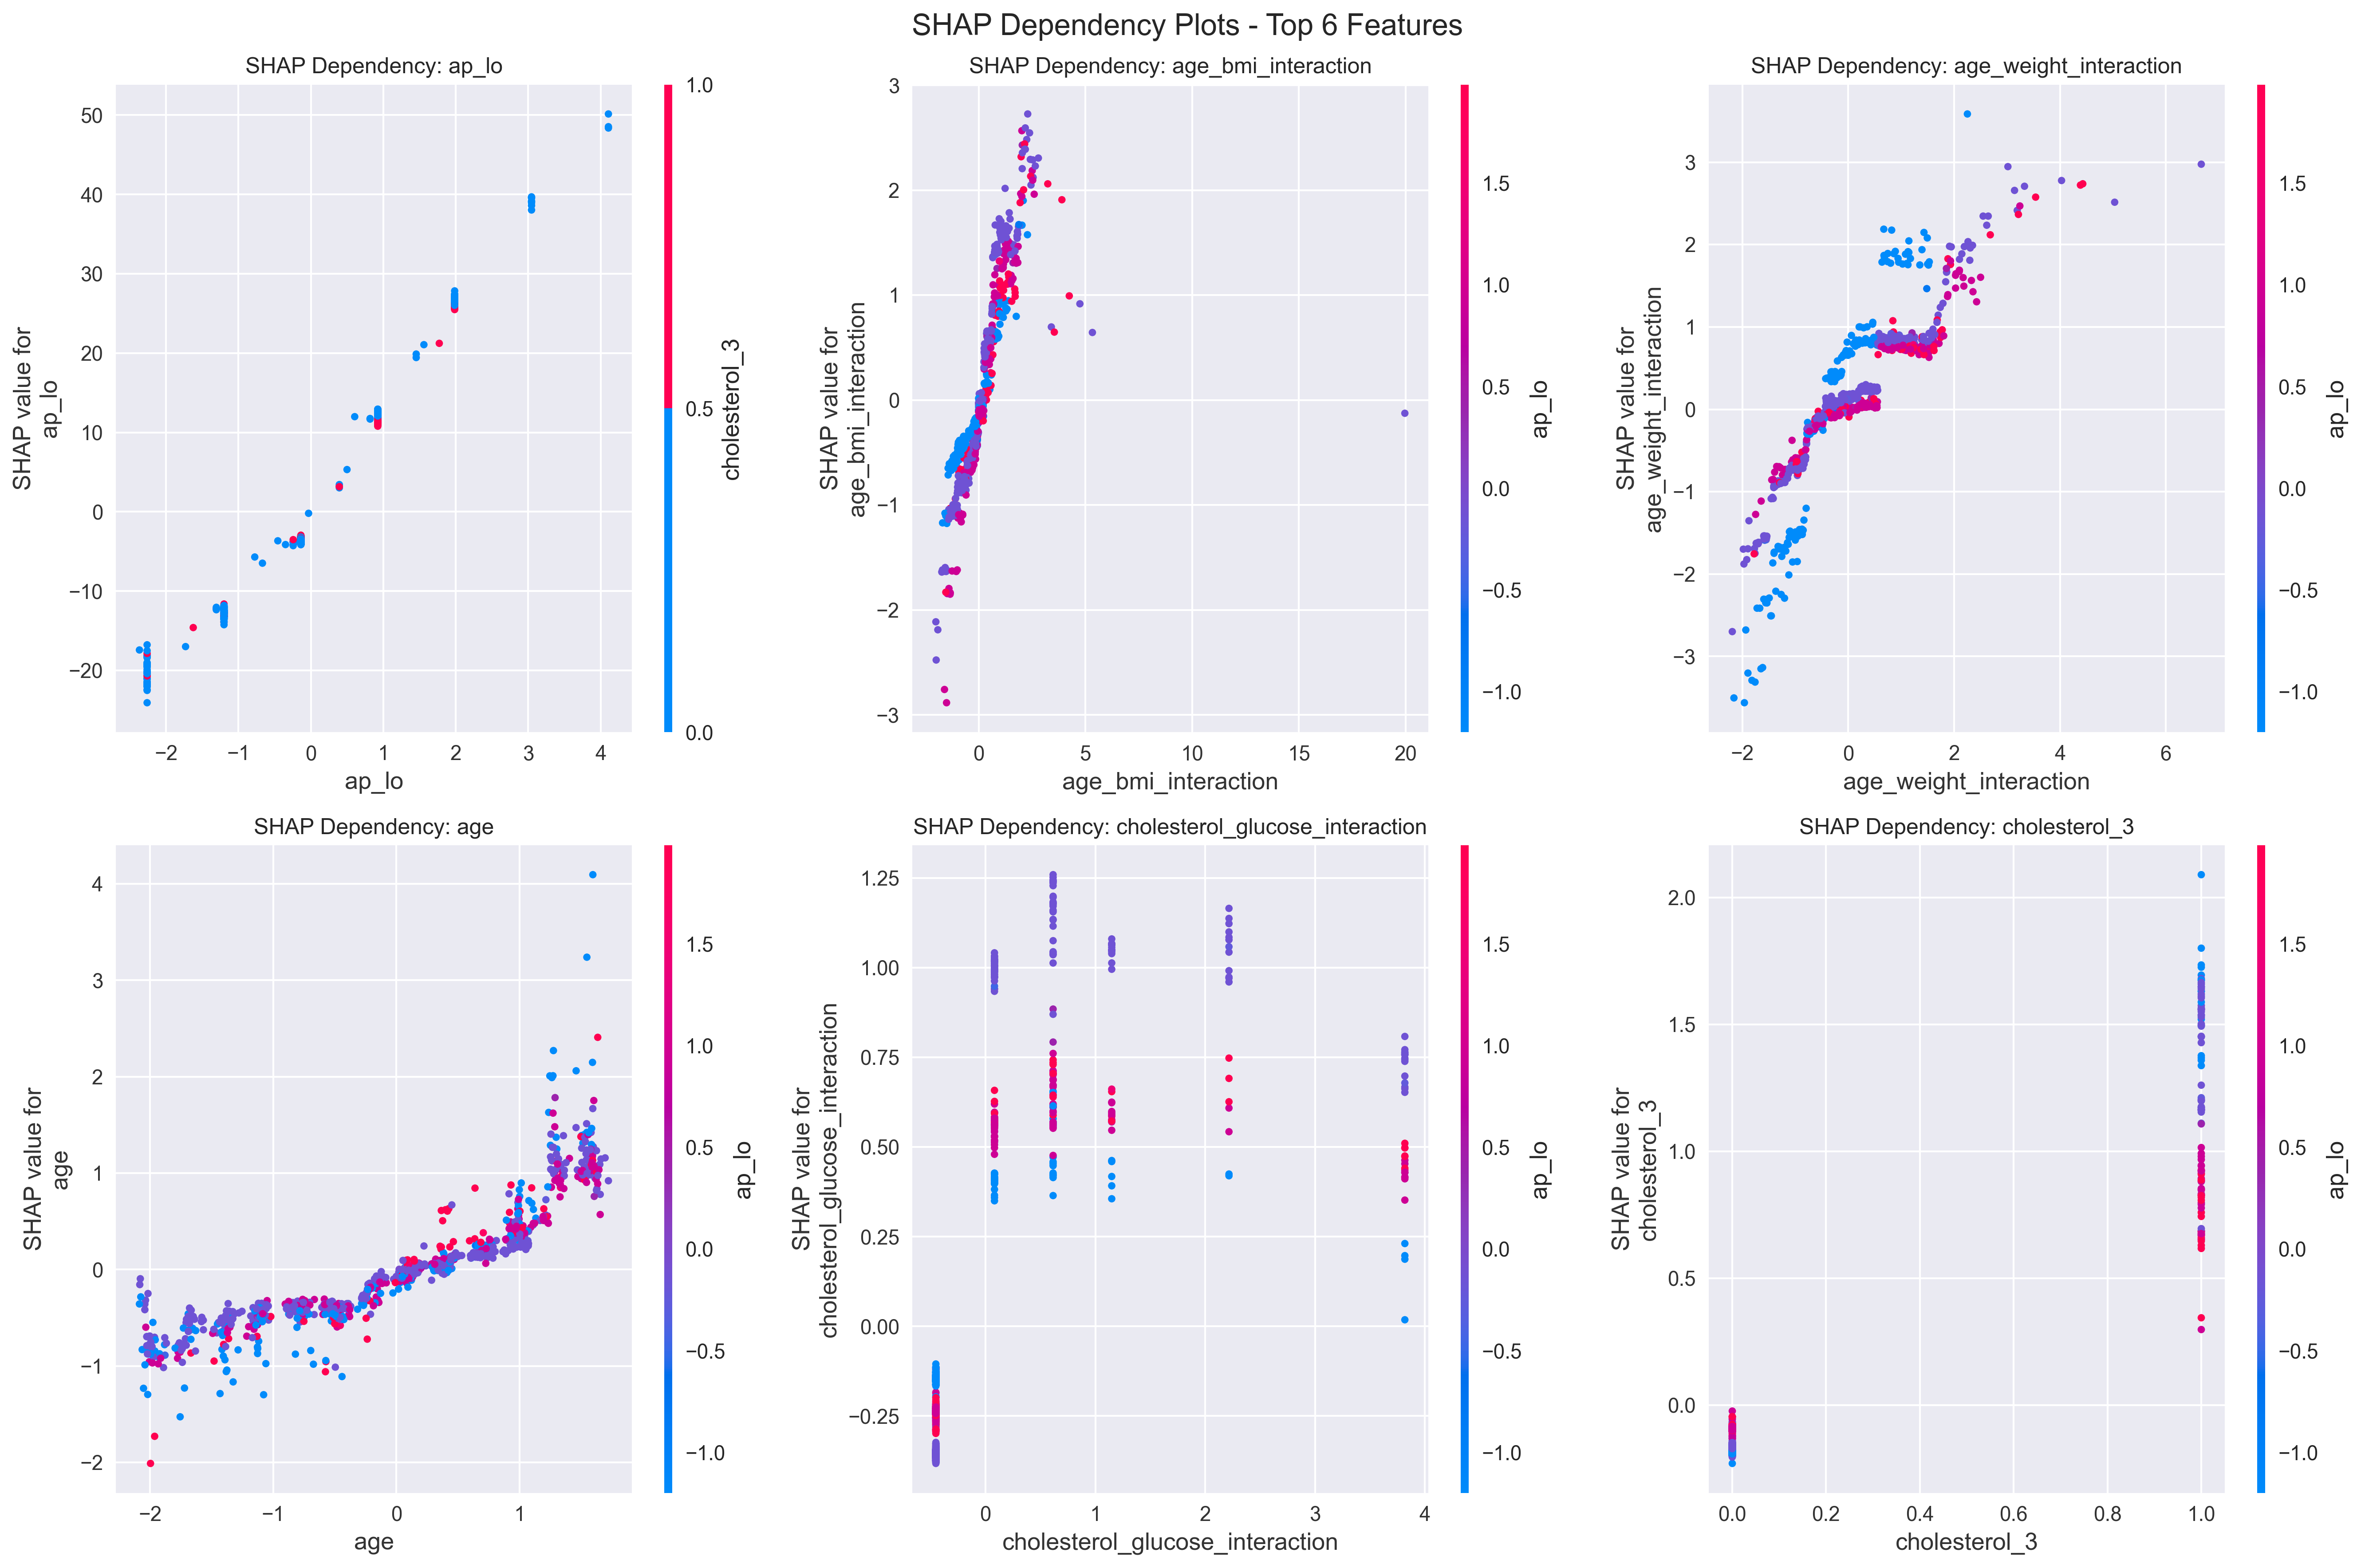

✓ SHAP dependency plots saved as vector (SVG) and PNG


In [23]:
# SHAP Dependency Plots for top features
print("Creating SHAP dependency plots...")

# Get feature importance ranking
feature_importance = np.abs(shap_values.values).mean(0)
top_features_idx = np.argsort(feature_importance)[-6:][::-1]  # Top 6 features

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature_idx in enumerate(top_features_idx):
    plt.sca(axes[i])
    shap.dependence_plot(
        feature_idx,
        shap_values.values,
        X_sample,
        feature_names=feature_names,
        show=False,
        ax=axes[i]
    )
    axes[i].set_title(f'SHAP Dependency: {feature_names[feature_idx]}', fontsize=12)

plt.suptitle('SHAP Dependency Plots - Top 6 Features', fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig('shap_dependency_plots.svg', format='svg', dpi=300, bbox_inches='tight')
plt.savefig('shap_dependency_plots.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP dependency plots saved as vector (SVG) and PNG")


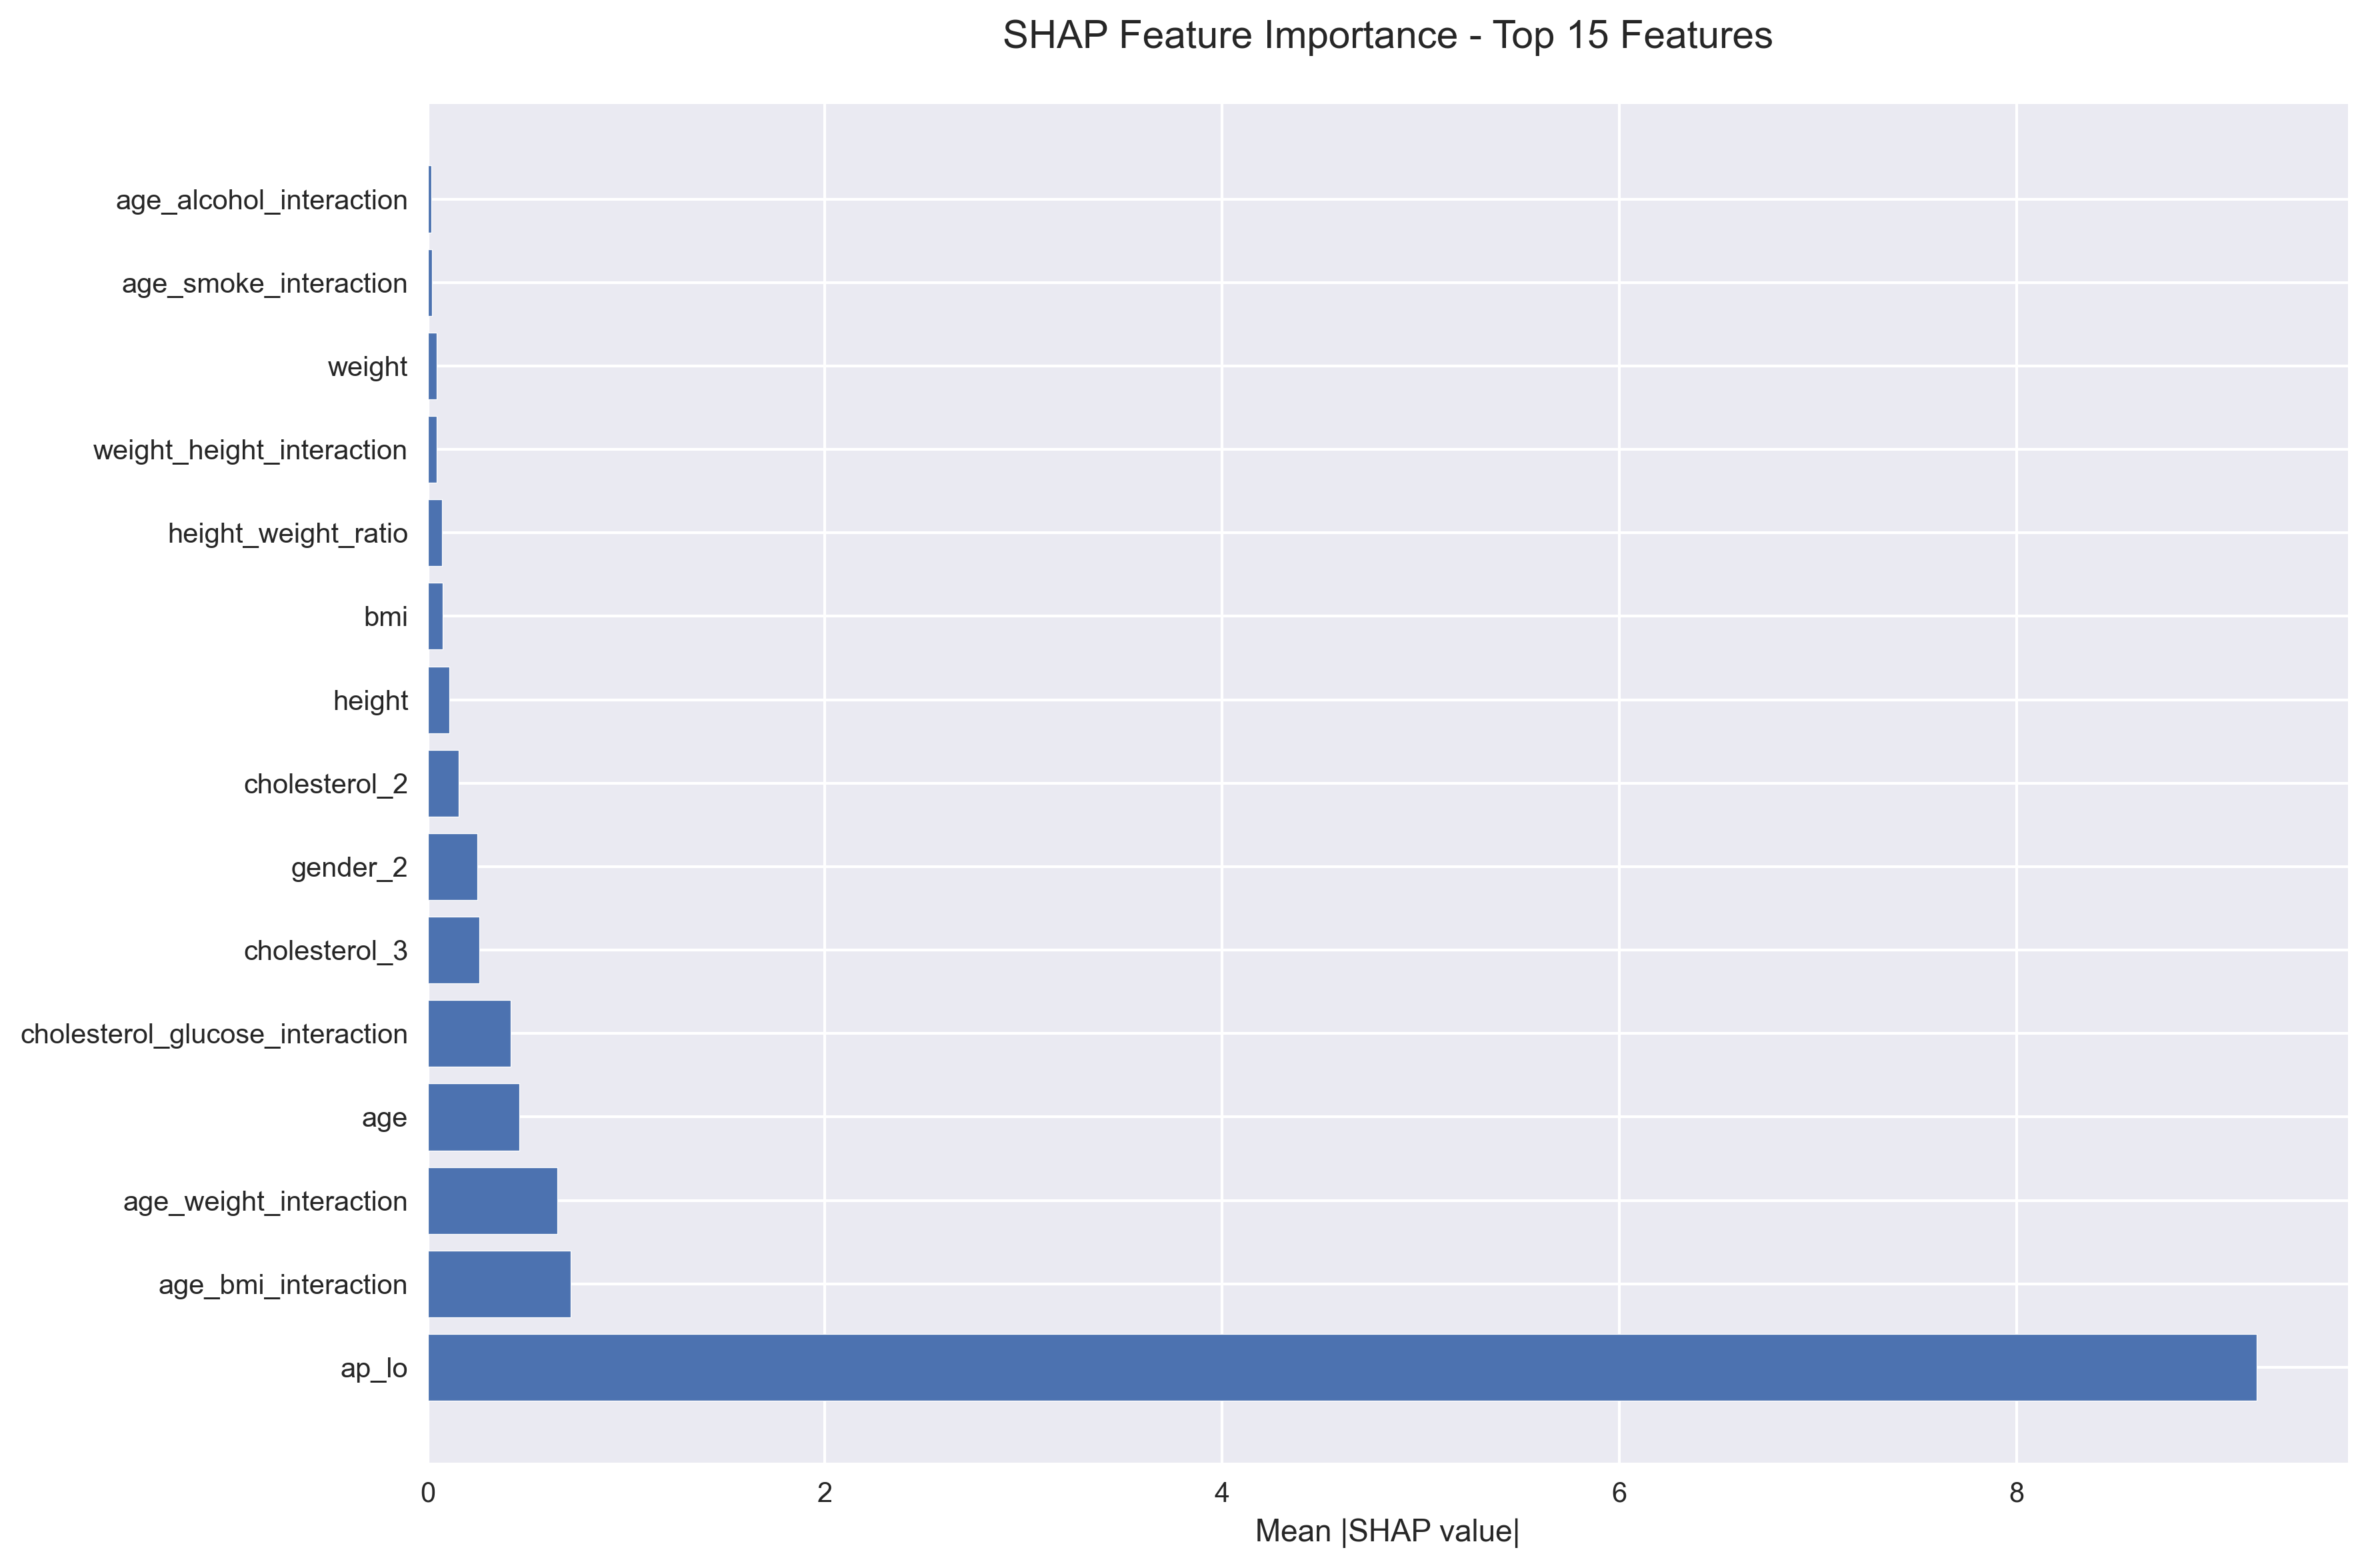

✓ SHAP feature importance plot saved as vector (SVG) and PNG


In [25]:
# Feature Importance Bar Plot with actual feature names
plt.figure(figsize=(12, 8))

# Create feature importance manually with proper names
feature_importance_values = np.abs(shap_values.values).mean(0)
sorted_idx = np.argsort(feature_importance_values)[-15:]  # Top 15 features

# Create DataFrame for plotting
importance_df = pd.DataFrame({
    'feature': [feature_names[i] for i in sorted_idx],
    'importance': feature_importance_values[sorted_idx]
})

# Create horizontal bar plot
plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Mean |SHAP value|')
plt.title('SHAP Feature Importance - Top 15 Features', fontsize=14, pad=20)
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.savefig('shap_feature_importance.svg', format='svg', dpi=300, bbox_inches='tight')
plt.savefig('shap_feature_importance.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP feature importance plot saved as vector (SVG) and PNG")


In [26]:
# STEP 6: Save Best Hyperparameters and Model Summary
print("\nSTEP 6: Save Best Hyperparameters and Final Model Summary")
print("="*50)

# Save best hyperparameters
hyperparams_df = pd.DataFrame([best_params]).T
hyperparams_df.columns = ['Best_Value']
hyperparams_df.index.name = 'Parameter'
hyperparams_df.to_csv('best_hyperparameters.csv')

print("Best Hyperparameters:")
print("="*30)
for param, value in best_params.items():
    print(f"{param}: {value}")

print(f"\nBest CV RMSE: {np.sqrt(-random_search.best_score_):.4f}")
print("✓ Best hyperparameters saved to best_hyperparameters.csv")

# Save additional model info
model_info = {
    'best_params': best_params,
    'best_cv_score': random_search.best_score_,
    'best_cv_rmse': np.sqrt(-random_search.best_score_),
    'feature_names': feature_names,
    'model_type': 'XGBoost Regressor',
    'target_variable': 'ap_hi (Systolic Blood Pressure)',
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("✓ Complete model information saved to model_info.pkl")

# Save the trained model
final_model.save_model('xgboost_final_model.json')
train_model.save_model('xgboost_train_model.json')

print("MODEL TRAINING COMPLETE!")
print("="*60)
print(f"✓ Best hyperparameters found and applied")
print(f"✓ Final model trained on full dataset ({X_full.shape[0]} samples)")
print(f"✓ Model performance metrics calculated and saved")
print(f"✓ Visualizations created and saved as high-DPI vector graphics")
print(f"✓ SHAP analysis completed with actual feature names")
print(f"✓ Models saved as JSON files")

print(f"\nFinal Model Performance Summary:")
print(f"  Training Set - RMSE: {metrics_df.loc[0, 'RMSE']:.2f} mmHg, R²: {metrics_df.loc[0, 'R2_Score']:.4f}")
print(f"  Test Set     - RMSE: {metrics_df.loc[1, 'RMSE']:.2f} mmHg, R²: {metrics_df.loc[1, 'R2_Score']:.4f}")
print(f"  Full Dataset - RMSE: {metrics_df.loc[2, 'RMSE']:.2f} mmHg, R²: {metrics_df.loc[2, 'R2_Score']:.4f}")

print(f"\nFiles Generated:")
print(f"  📊 model_metrics.csv - Performance metrics")
print(f"  📈 true_vs_predicted.svg/png - Prediction accuracy plots")
print(f"  📈 residual_plots.svg/png - Residual analysis")
print(f"  📊 shap_summary_plot.svg/png - SHAP feature importance")
print(f"  📈 shap_dependency_plots.svg/png - SHAP dependency analysis")
print(f"  📊 shap_feature_importance.svg/png - Feature importance ranking")
print(f"  🤖 xgboost_final_model.json - Trained model (full data)")
print(f"  🤖 xgboost_train_model.json - Trained model (train only)")

print(f"\nModel is ready for deployment and can predict systolic blood pressure!")



STEP 6: Save Best Hyperparameters and Final Model Summary
Best Hyperparameters:
subsample: 0.9
reg_lambda: 2.5
reg_alpha: 1.0
n_estimators: 300
min_child_weight: 1
max_depth: 3
learning_rate: 0.05
colsample_bytree: 1.0

Best CV RMSE: 10.7527
✓ Best hyperparameters saved to best_hyperparameters.csv
✓ Complete model information saved to model_info.pkl
MODEL TRAINING COMPLETE!
✓ Best hyperparameters found and applied
✓ Final model trained on full dataset (68666 samples)
✓ Model performance metrics calculated and saved
✓ Visualizations created and saved as high-DPI vector graphics
✓ SHAP analysis completed with actual feature names
✓ Models saved as JSON files

Final Model Performance Summary:
  Training Set - RMSE: 10.63 mmHg, R²: 0.5927
  Test Set     - RMSE: 10.80 mmHg, R²: 0.5891
  Full Dataset - RMSE: 10.65 mmHg, R²: 0.5925

Files Generated:
  📊 model_metrics.csv - Performance metrics
  📈 true_vs_predicted.svg/png - Prediction accuracy plots
  📈 residual_plots.svg/png - Residual anal